In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [3]:
df_test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
df_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [4]:
# Extract labels and features
y_train = df_train['label']
df_train.drop(['label'], axis=1, inplace=True)

y_test = df_test['label']
df_test.drop(['label'], axis=1, inplace=True)

In [5]:
# Define constants and reshape the data
size = 28
channels = 1
batch = 128
epochs = 100

X_train = df_train.values.reshape(df_train.shape[0], size, size, channels)
X_test = df_test.values.reshape(df_test.shape[0], size, size, channels)

In [6]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=.2,
    height_shift_range=.2,
    rotation_range=15,
    brightness_range=[0.8, 1.2],
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

X_train = train_datagen.flow(X_train, y_train, batch_size=batch)
X_test = test_datagen.flow(X_test, y_test)

In [7]:
# Define the model architecture
Model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(size, size, channels)),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), activation="relu"),
    MaxPool2D(2, 2, padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(units=4096, activation="relu"),
    Dropout(0.5),
    Dense(units=1024, activation="relu"),
    Dropout(0.5),
    Dense(units=25, activation="softmax"),
])

# Compile the model
Model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [8]:
# Model callbacks
checkpoint_filepath = 'best_model.hdf5'
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='loss', mode='min', min_delta=0.01, patience=3, factor=.75, min_lr=0.00001, verbose=1)
callbacks = [callback_checkpoint, callback_learningrate]

In [9]:
# Train the model
history = Model.fit(X_train, validation_data=X_test, epochs=epochs, callbacks=callbacks)

Epoch 1/100


2023-10-21 02:59:14.076851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 26s 79ms/step - loss: 3.1724 - accuracy: 0.0602 - val_loss: 2.8866 - val_accuracy: 0.0951 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 17s 77ms/step - loss: 2.3495 - accuracy: 0.2514 - val_loss: 1.2673 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 17s 79ms/step - loss: 1.2927 - accuracy: 0.5624 - val_loss: 0.4610 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 17s 78ms/step - loss: 0.8428 - accuracy: 0.7201 - val_loss: 0.2719 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 17s 78ms/step - loss: 1.0054 - accuracy: 0.7292 - val_loss: 0.1588 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 16s 75ms/step - loss: 0.7374 - accuracy: 0.8069 - val_loss: 0.1471 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 7/100
215/215 [==============================] - 17s 77ms/

In [10]:
# Model evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

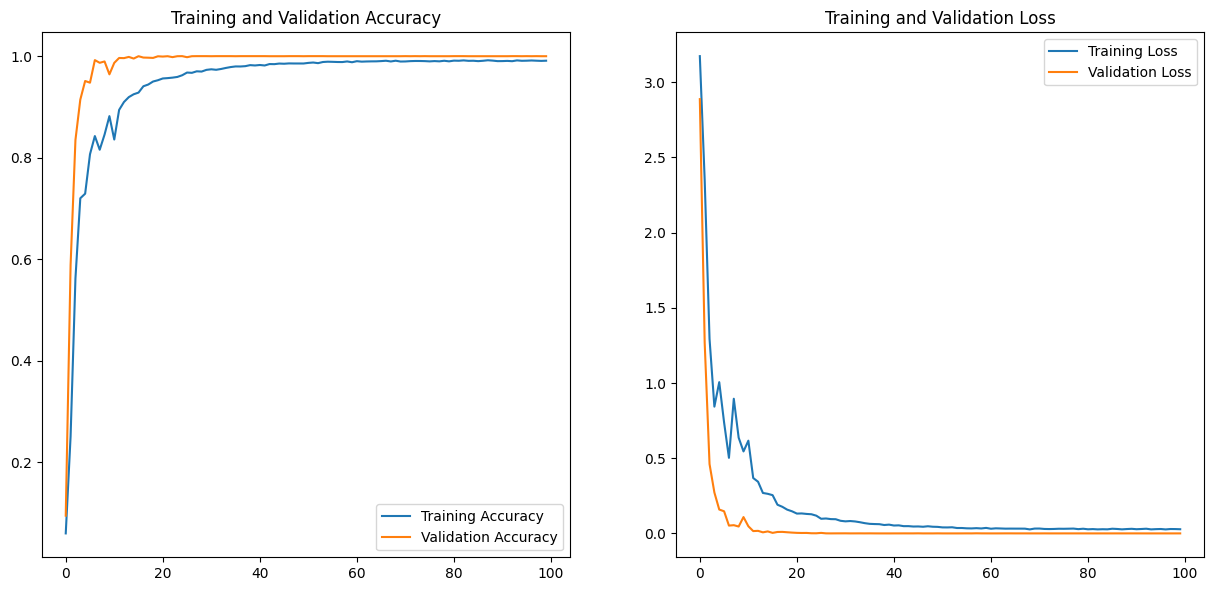

In [11]:
# Visualize training history
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Model evaluation on the test data
print(f'Test Acc: {Model.evaluate(X_test)[1] * 100:.2f}%')

225/225 [==============================] - 1s 4ms/step - loss: 2.1673e-04 - accuracy: 0.9999
Test Acc: 99.99%


225/225 [==============================] - 1s 3ms/step


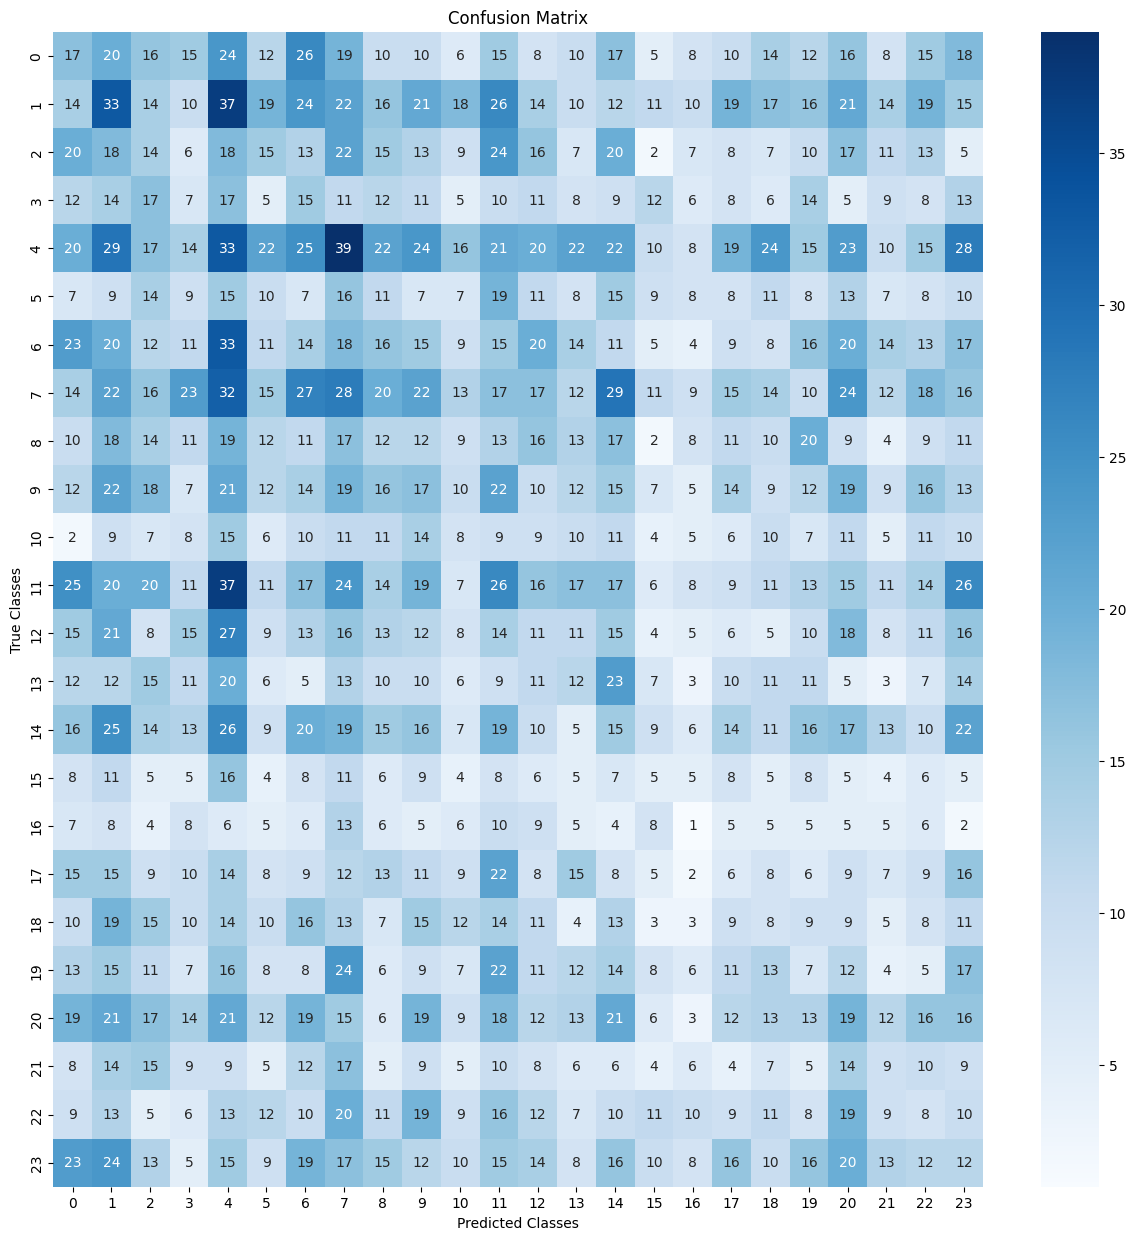

In [13]:
# Confusion Matrix
y_pred = np.argmax(Model.predict(X_test), axis=1)
CM = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(CM, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

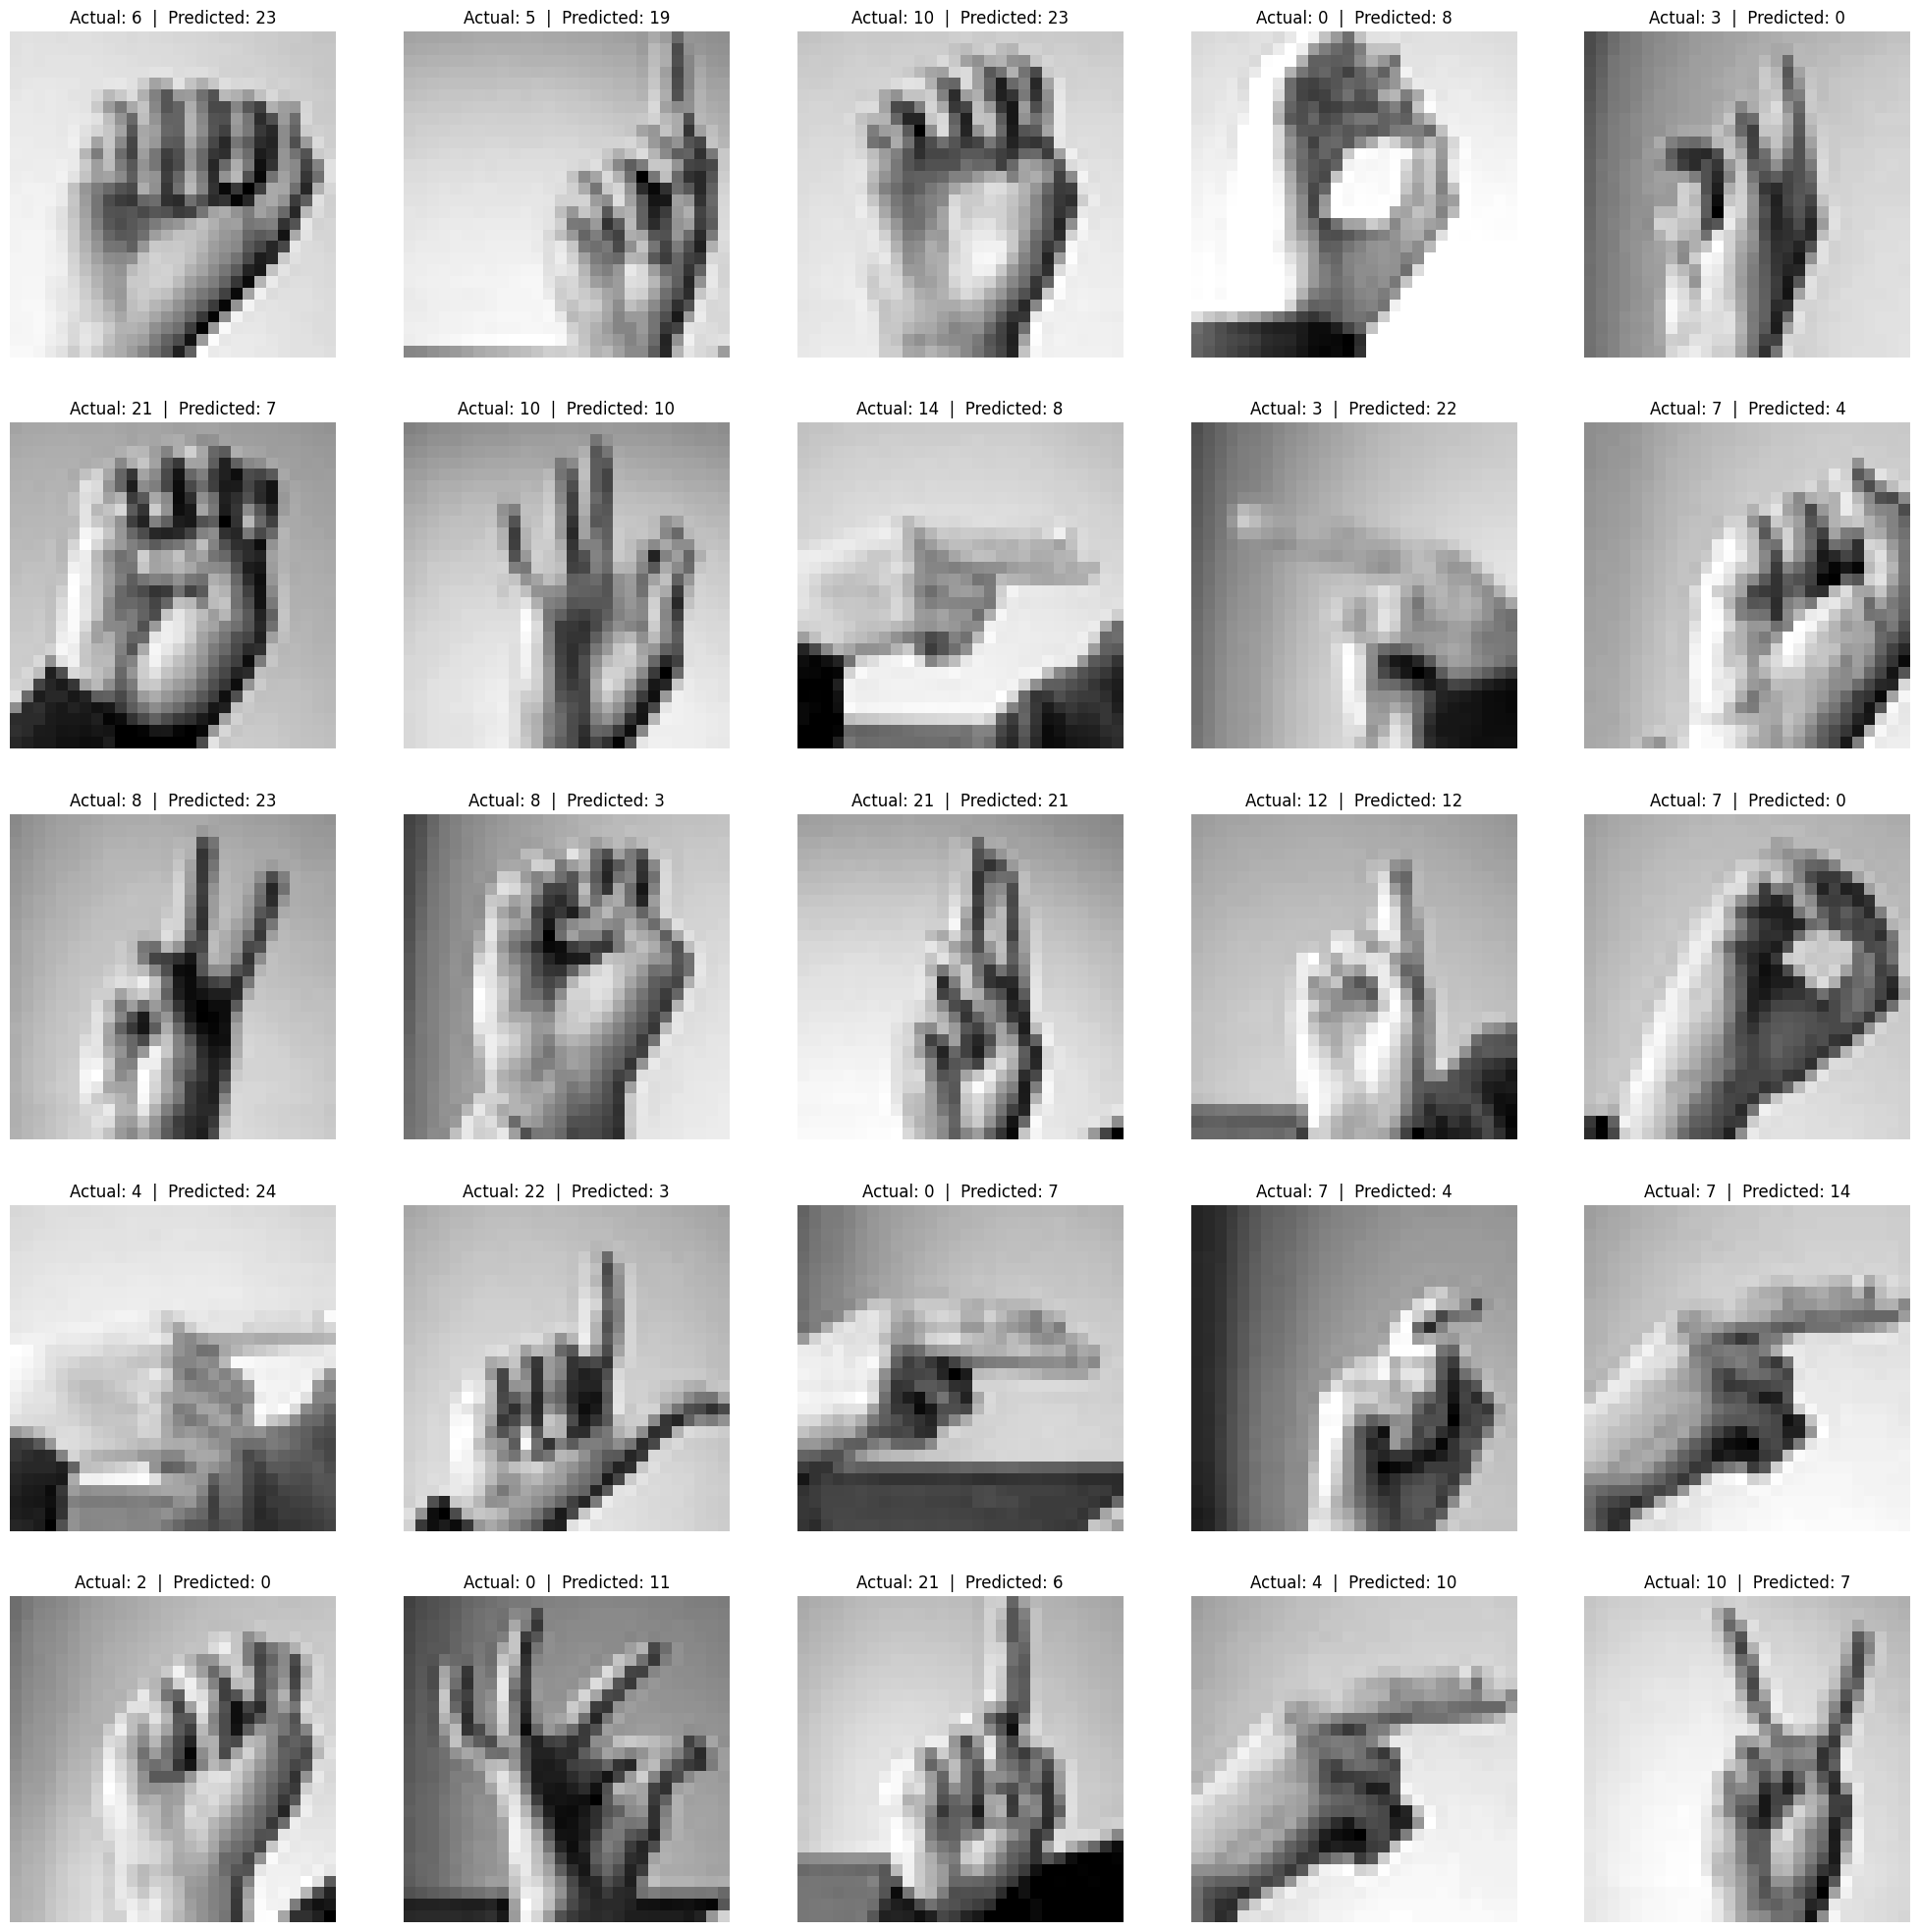

In [14]:
# Sample Image Visualization
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(next(X_test)[0][0, :, :, 0], cmap='gray')
    plt.title(f'Actual: {y_test[i]}  |  Predicted: {y_pred[i]}')
    plt.axis('off')
plt.show()